In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pickle as pk
import numpy as np
import pandas as pd


# from __future__ import division
# from __future__ import print_function

from tensorflow.keras.layers import Lambda, Dense, TimeDistributed, Input, Flatten, MaxPool2D, Reshape, Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, concatenate, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
 

# from vgg16 import VGG16
from tensorflow.keras.applications import VGG16, VGG19, DenseNet201
from tensorflow.keras.applications.vgg16 import preprocess_input

import scipy.io
from scipy.spatial.distance import braycurtis, cosine, canberra, chebyshev, cityblock, correlation, euclidean, mahalanobis, minkowski, seuclidean, sqeuclidean, wminkowski 
import os
import matplotlib.pyplot as plt
import cv2
from time import time


# !gdown --id 1IjCE3DwfHCPf2dZPHqSzU68QdaY7js6C --output best.pt
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5
# !git reset --hard 886f1c03d839575afecb059accf74296fad395b6
# !pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch
from IPython.display import Image, clear_output 
from os import listdir
from os.path import join, splitext, split, exists, isdir
from PIL import Image as Im
import numpy as np
from os import listdir
from shutil import copy, rmtree

# Формируем эмбеддинги для всех изображений

In [4]:
def contrast(img, contrast):
    clahe = cv2.createCLAHE(clipLimit=contrast, tileGridSize=(5,5))
    return clahe.apply(img)

def get_edges(img):
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    img1 = contrast(img, 1)
    img2 = contrast(img, 2)
    img3 = contrast(img, 3)
    return np.stack([img1, img2, img3], axis=2)


def load_image(path):
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR), (224, 224))

    return img

In [5]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

cast = {'dice_coef':dice_coef}

segmentation_model = load_model('/content/drive/Othercomputers/Мое устройство Компьютер/coin_country_classification/segmentation_coin.h5', custom_objects=cast)

In [6]:
df = pd.read_csv('/content/drive/Othercomputers/Мое устройство Компьютер/coin_country_classification/csv/catalog.csv')
images = df.values[:,0]
# images = os.listdir('/content/drive/MyDrive/Проекты ML/coin_country_classification/images (1)/image')
print(images)

[1 2 12 ... 79146 79147 79148]


In [7]:
def segmentation(images):
    images = np.array(images)
    predict = (segmentation_model.predict(images)).round().reshape(2, 224, 224)
    mask = np.stack([predict, predict, predict], axis=3)
    img = images.copy()
    img[mask==0] = 255
    idx1 = np.argwhere(np.all(mask[..., :] == 0, axis=1))
    idx2 = np.argwhere(np.all(mask[..., :] == 0, axis=2))
    images = np.delete(images, idx1, axis=2)
    images = np.delete(images, idx2, axis=1)
    images = np.array(list(map(lambda x:cv2.resize(x, (224, 224)), images)))
    return images

In [11]:
def test(df, filenames, embeddings, model, distance, title, model_name, show=True):
    imgs = image_array2(filenames[0], filenames[1])
    seg = segmentation(imgs)
    imga, imgr = seg
    folder = filenames[0].split('/')[-2]
    img = model.predict(np.vstack([preprocess_input(get_edges(imga)).reshape(1,224,224,3), 
                                    preprocess_input(get_edges(imgr)).reshape(1,224,224,3),
                                    ]))


    img_seg = img[0] + img[1]

    predict_cos_seg = []
    start = time()
    for embedding, pca in zip(embeddings, embeddings8000): # zip(embeddings, embeddings8000):
        predict_cos_seg.append(distance(img_seg, embedding))
    predict_cos_seg = np.array(predict_cos_seg)

    print(time() - start)
    result_answer_seg = int(folder) in df.iloc[np.argsort(predict_cos_seg)[:10]].values[:,0]
    result_position_seg = np.where(df.iloc[np.argsort(predict_cos_seg)].values[:,0] == int(folder))[0][0]
    result_cos_seg = predict_cos_seg[np.argsort(predict_cos_seg)][np.where(df.iloc[np.argsort(predict_cos_seg)].values[:,0] == int(folder))[0][0]]


    result = [result_answer_seg, result_position_seg, result_cos_seg]

    if result_answer_seg:
        return result
    
    result_position = result_position_seg
    predict_cos = result_cos_seg
    result_answer = result_answer_seg
    save_folder = 'embeddings'
    if show:
        plt.figure(figsize=(20, 12))
        plt.subplot(4, 6, 1)
        # plt.imshow(load_image(os.path.join(filenames, names[0])))
        plt.imshow(imga)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(f'Input: {folder}\n{result_position}')
        plt.subplot(4, 6, 2)
        # plt.imshow(load_image(os.path.join(filenames, names[1])))
        plt.imshow(imgr)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(f'Input\n{folder}')
        plt.subplot(4, 6, 3)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        pred_name = f'images/{folder}_a.jpg'
        plt.imshow(cv2.resize(cv2.imread(pred_name, cv2.IMREAD_COLOR), (224, 224)))
        # plt.imshow(imgs[0])
        plt.xlabel(f'в базе')
        plt.subplot(4, 6, 4)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        pred_name = f'images/{folder}_r.jpg'
        plt.imshow(cv2.resize(cv2.imread(pred_name, cv2.IMREAD_COLOR), (224, 224)))
        # plt.imshow(imgs[1])
        plt.xlabel(f'в базе')
        j = 5
        for n, i in enumerate(np.argsort(predict_cos)[:10]):
            plt.subplot(4, 6, j)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            pred_name = f'images/{df.values[i][0]}_a.jpg'
            plt.imshow(cv2.resize(cv2.imread(pred_name, cv2.IMREAD_COLOR), (224, 224)))
            # plt.imshow(imgs[0])
            plt.xlabel(f'dist: {round(predict_cos[i], 4)}\nn:{df.values[i][0]}_a')
            plt.subplot(4, 6, j + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            pred_name = f'images/{df.values[i][0]}_r.jpg'
            plt.imshow(cv2.resize(cv2.imread(pred_name, cv2.IMREAD_COLOR), (224, 224)))
            # plt.imshow(imgs[1])
            plt.xlabel(f'dist: {round(predict_cos[i], 4)}\nn:{df.values[i][0]}_r')
            j += 2
        plt.suptitle(title + ' - ' + str(result_answer))
        # plt.suptitle(title)
        plt.savefig(f'{save_folder}/{title}_{result_answer}.png')
        plt.show()

    return result
    # return 1

In [12]:
distance = [braycurtis, cosine, canberra, chebyshev, cityblock, correlation, 
            euclidean, minkowski, sqeuclidean]
distance_name = ['braycurtis', 'cosine', 'canberra', 'chebyshev', 'cityblock', 'correlation', 
            'euclidean', 'minkowski', 'sqeuclidean']

[0.5204081632653061, 0.5408163265306123, 0.6122448979591837]

[47, 45, 38]

In [13]:
def create_vgg19():
  vgg_model = VGG19(weights='imagenet')
  return Model(inputs=vgg_model.layers[0].input, outputs=vgg_model.layers[-4].output)


def create_vgg16():
  vgg_model = VGG16(weights='imagenet')
  return Model(inputs=vgg_model.layers[0].input, outputs=vgg_model.layers[-4].output)


def create_dense():
  dense_model =  DenseNet201()
  return Model(dense_model.input, dense_model.layers[-2].output)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='/content/_val', update=False, view_img=False, weights=['/content/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CPU

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 232 layers, 7249215 parameters, 0 gradients, 16.8 GFLOPS
image 1/2 /content/_val/230223304.0.jpg: 416x416 1 money, Done. (0.268s)
image 2/2 /content/_val/230223304.1.jpg: 416x416 1 money, Done. (0.127s)
Results saved

error: ignored

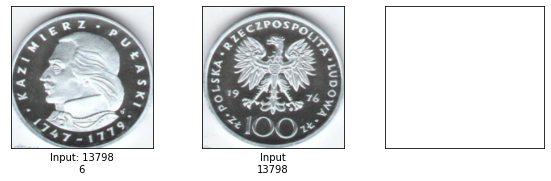

In [16]:
model = create_vgg19()
embeddings = np.load(f'embeddingsOconcon_VGG19.npy')
accuracy = []
count_list = []
not_found_list = []
results = {'catalog':[], 'result_answer_seg':[], 'result_position_seg':[], 'result_cos_seg':[]}
acc = []
count = 0
not_found = []
start = time()
i = 0
test_path = '/content/drive/MyDrive/Проекты ML/coin_country_classification/coin_country_classification/test'
for folder in os.listdir(test_path)[2:]:
    if len(list(filter(lambda x: 'ob' in x, os.listdir(os.path.join(test_path, folder))))) == 2:
        images_name = list(filter(lambda x: 'ob' in x, os.listdir(os.path.join(test_path, folder))))
    else:
        images_name = list(filter(lambda x: not 'ob' in x, os.listdir(os.path.join(test_path, folder))))
    filepaths = [os.path.join(test_path, folder) + '/' + images_name[0],
                os.path.join(test_path, folder) + '/' + images_name[1]]
    try:
        predict = test(df, filepaths, embeddings, model, distance[1], f'{folder}', 'not_found', )
    except Exception as ex:
      print(ex)
      continue
    results['catalog'].append(int(folder))
    for key, value in zip(list(results.keys())[1:], predict):
        results[key].append(value)
    i += 1
resultfarme = pd.DataFrame(data=results)

In [ ]:
 list(results.keys())

In [ ]:
del results[list(results.keys())[4]]

In [ ]:
resultfarme = pd.DataFrame(data=results)

In [ ]:
resultframe.head(50)

In [ ]:
# resultframe[list(filter(lambda x: 'seg' in x or x == 'catalog', resultframe.columns))][resultframe['result_answer_seg'] == False].head(50)

,catalog,result_answer_seg,result_position_seg,result_cos_seg
18,11651,False,21,0.361160
22,10810,False,11,0.277990
23,1620,False,36,0.292278
28,15434,False,44,0.569273
29,13350,False,712,0.625256
31,13997,False,11,0.236715
33,11803,False,6848,0.564703
38,27195,False,11,0.486325
42,24203,False,845,0.448799
57,27698,False,5448,0.564506


In [ ]:
resultframe[resultframe['result_answer_seg'] == False].head(50)

,catalog,result_answer_seg,result_position_seg,result_cos_seg
18,11651,False,21,0.361160
22,10810,False,11,0.277990
23,1620,False,36,0.292278
28,15434,False,44,0.569273
29,13350,False,712,0.625256
31,13997,False,11,0.236715
33,11803,False,6848,0.564703
38,27195,False,11,0.486325
42,24203,False,845,0.448799
57,27698,False,5448,0.564506


In [ ]:
not_found = dict()
for i in range(1, len(resultframe.columns), 3):
  print(resultframe.columns[i])
  count = resultframe[resultframe[resultframe.columns[i]] == False].shape[0]
  not_found[resultframe.columns[i]] = count
not_found_frame = pd.DataFrame(data=not_found, index=['count'])

result_answer_seg


In [ ]:
not_found_frame.head()

,result_answer_seg
count,22
